In [1]:
# Bank Customer Churn Prediction Analysis
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Data Loading and Initial Exploration
# Load the dataset
df = pd.read_csv('Bank Customer Churn Prediction.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

# Display first few rows
print("\nFirst few rows of the dataset:")
print(df.head())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None

First few rows of the dataset:
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   


Overall churn rate: 20.37%


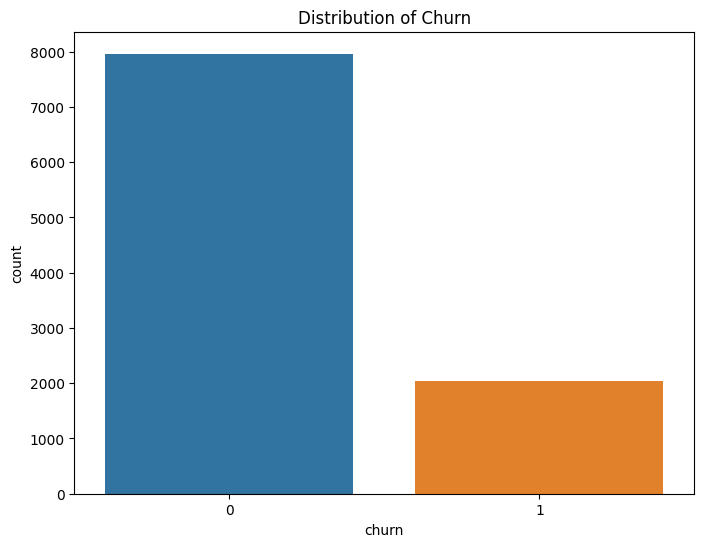

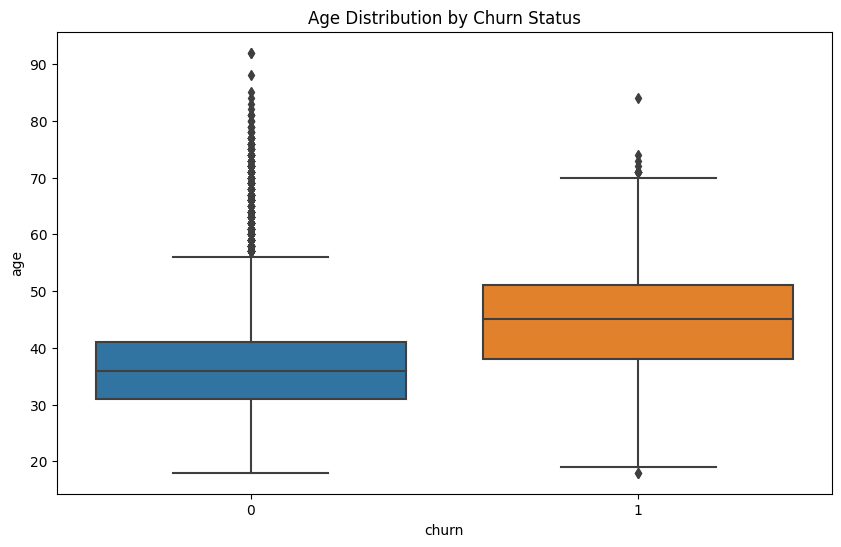

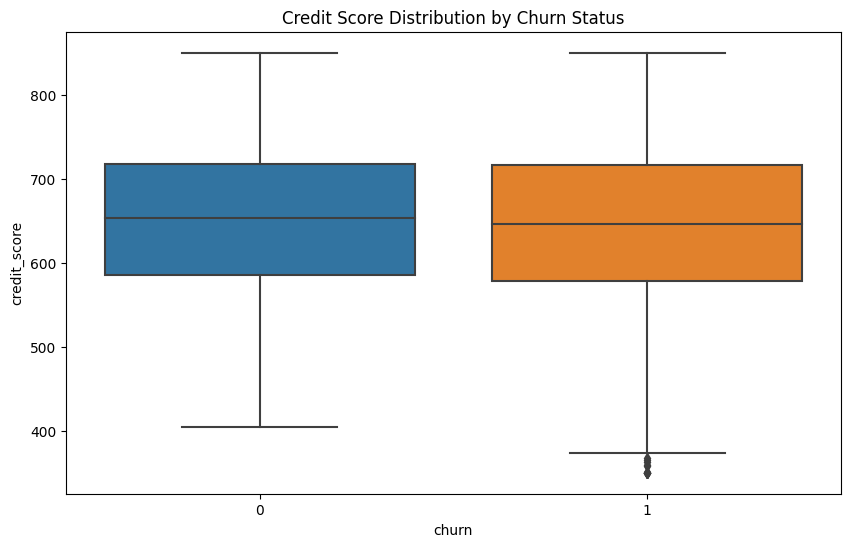

In [3]:
# Data Analysis and Visualization
# Calculate churn rate
churn_rate = (df['churn'].mean() * 100)
print(f"\nOverall churn rate: {churn_rate:.2f}%")

# Visualize churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='churn')
plt.title('Distribution of Churn')
plt.show()

# Analyze churn by age
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='churn', y='age')
plt.title('Age Distribution by Churn Status')
plt.show()

# Analyze churn by credit score
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='churn', y='credit_score')
plt.title('Credit Score Distribution by Churn Status')
plt.show()

In [4]:
# Data Preprocessing
# Create a copy of the dataframe
data = df.copy()

# Encode categorical variables
le = LabelEncoder()
data['gender'] = le.fit_transform(data['gender'])
data['country'] = le.fit_transform(data['country'])

# Feature engineering
# Calculate balance per product ratio
data['balance_per_product'] = data['balance'] / (data['products_number'] + 1)

# Create age groups
data['age_group'] = pd.cut(data['age'], 
                          bins=[0, 20, 30, 40, 50, 60, 100],
                          labels=['0-20', '21-30', '31-40', '41-50', '51-60', '60+'])

# Create tenure groups
data['tenure_group'] = pd.cut(data['tenure'],
                             bins=[0, 2, 5, 8, 10],
                             labels=['0-2', '3-5', '6-8', '9-10'])

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['age_group', 'tenure_group'])

# Prepare features for modeling
# Drop unnecessary columns
features_to_drop = ['customer_id', 'churn']
X = data.drop(features_to_drop, axis=1)
y = data['churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 
                     'estimated_salary', 'balance_per_product']

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [5]:
# Model Training
# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, 
                             max_depth=10,
                             min_samples_split=5,
                             min_samples_leaf=2,
                             random_state=42)

model.fit(X_train, y_train)

# Model Evaluation
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      1607
           1       0.81      0.43      0.56       393

    accuracy                           0.87      2000
   macro avg       0.84      0.70      0.74      2000
weighted avg       0.86      0.87      0.85      2000


ROC-AUC Score: 0.862

Cross-validation ROC-AUC Scores: [0.83905459 0.84124938 0.86642641 0.85220933 0.85164017]
Average CV Score: 0.850 (+/- 0.019)


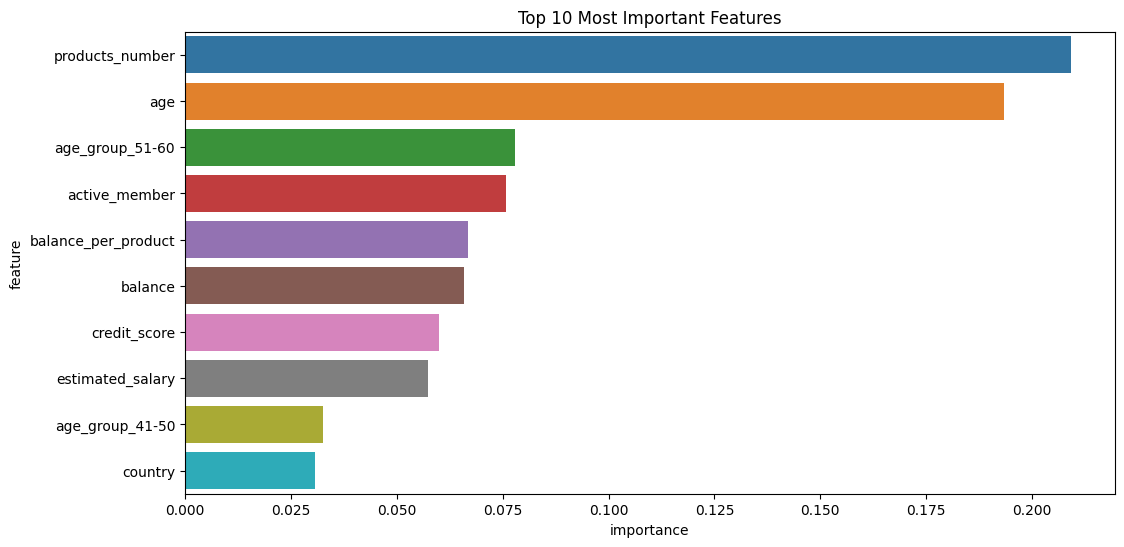


Top 10 Most Important Features:
                feature  importance
6       products_number    0.209074
3                   age    0.193330
15      age_group_51-60    0.077953
8         active_member    0.075886
10  balance_per_product    0.066902
5               balance    0.065925
0          credit_score    0.059912
9      estimated_salary    0.057444
14      age_group_41-50    0.032537
1               country    0.030702


In [6]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.3f}")

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC-AUC Scores: {cv_scores}")
print(f"Average CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Feature Importance Analysis
# Calculate and visualize feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

In [7]:
# Make predictions on new data
# Example of how to make predictions on new customers
def predict_churn_probability(model, customer_data, scaler, numerical_features):
    """
    Make predictions for new customers
    """
    # Preprocess the customer data (ensure it has the same features as training data)
    customer_data[numerical_features] = scaler.transform(customer_data[numerical_features])
    
    # Make prediction
    churn_probability = model.predict_proba(customer_data)[:, 1]
    
    return churn_probability